In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

In [2]:
import nltk

In [3]:
import sqlite3, json, re

In [4]:
RATIO = 0.618

### GET field names    

In [5]:
conn = sqlite3.connect('arxiv.db')
cursor = conn.cursor()

info = cursor.execute("PRAGMA TABLE_INFO(arxiv)")
field_names = [record[1] for record in info]
print(field_names)

cursor.close()
conn.close()

['abstract', 'authors', 'authors_parsed', 'categories', 'comments', 'doi', 'id', 'journal-ref', 'license', 'report-no', 'submitter', 'title', 'update_date', 'versions']


### SELECT categories and update_date from table

In [8]:
def get_date_and_cats():
    with sqlite3.connect('arxiv.db') as conn:
        cursor = conn.cursor()
        query = 'SELECT id, update_date, categories FROM arxiv ORDER BY update_date'
        query_result = cursor.execute(query)
        data = pd.DataFrame(query_result.fetchall())
        data.columns = ['id', 'update_date', 'categories']
        data = data.set_index(data.id).drop(columns=['id'])
        cursor.close()

    return data

In [9]:
data = get_date_and_cats()
data.head()

,update_date,categories
id,,
0704.0004,2007-05-23,math.CO
0704.0010,2007-05-23,math.CO
0704.0012,2007-05-23,math.NT
0704.0018,2007-05-23,hep-th
0704.0034,2007-05-23,q-bio.PE q-bio.CB quant-ph


In [10]:
data['year-month'] = data.update_date.str.extract(r'([0-9]+-[0-9]+)-[0-9]+')
data['year'] = data.update_date.str.extract(r'([0-9]+)-[0-9]+-[0-9]+')

In [22]:
year_groups = data.groupby('year').apply(len)
year_groups

year
2007    146648
2008     69535
2009    229386
2010     56492
2011     62190
2012     57709
2013     72579
2014     88881
2015    216670
2016    135461
2017    125866
2018    143191
2019    177383
2020    165316
dtype: int64

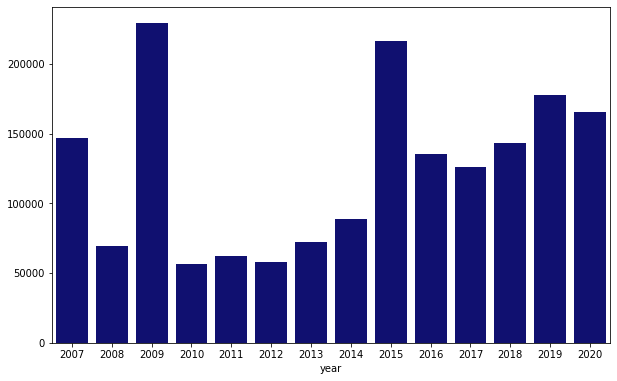

In [23]:
plt.figure(figsize=(10, 10*RATIO))
sns.barplot(x=year_groups.index, y=year_groups, color='navy')

### Top10 categories in arxiv

In [24]:
cate_series_raw = data.categories.str.split(' ')

In [25]:
cat_numbers = {}
for i in range(cate_series_raw.shape[0]):
    for cat in cate_series_raw[i]:
        cat_numbers[cat] = cat_numbers.get(cat,0) + 1

In [26]:
cate_se = pd.Series(cat_numbers, index=cat_numbers.keys())

In [27]:
# The top-10 categories
top10_cate = cate_se.sort_values(ascending=False)[:10]

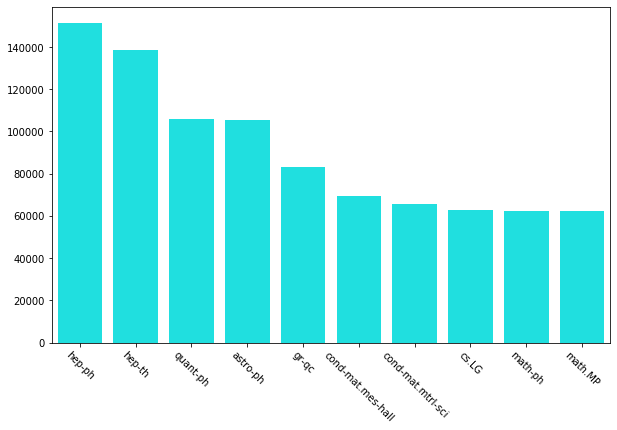

In [28]:
fig = plt.figure(figsize=(10, 10*RATIO))

ax = sns.barplot(x=top10_cate.index, y=top10_cate,color='aqua')
for tick in ax.get_xticklabels():
    tick.set_rotation(-45)

### Top authors in quant-ph category

In [29]:
def get_authors_in_quantph():
    with sqlite3.connect('arxiv.db') as conn:
        cursor = conn.cursor()
        query = '''SELECT id, update_date, authors 
                   FROM arxiv 
                   WHERE categories LIKE '%quant-ph%'
                   ORDER BY update_date'''
        query_result = cursor.execute(query)
        data = pd.DataFrame(query_result.fetchall())
        data.columns = ['id', 'update_date', 'authors']
        data = data.set_index(data.id).drop(columns=['id'])
        cursor.close()

    return data

In [30]:
data_author = get_authors_in_quantph()
data_author.head()

,update_date,authors
id,,
0704.0034,2007-05-23,Vasily Ogryzko
0704.0214,2007-05-23,Miloslav Znojil
0704.0340,2007-05-23,"Fam Le Kien, S. Dutta Gupta, and K. Hakuta"
0704.0373,2007-05-23,"Utpal Roy, Suranjana Ghosh, T. Shreecharan, an..."
0704.0420,2007-05-23,Donald McCartor


In [68]:
author_series_raw = data_author.authors.str.replace(' and',',').str.replace('\n','').str.split(',')
author_series_raw.head(20)

id
0704.0034                                     [Vasily Ogryzko]
0704.0214                                    [Miloslav Znojil]
0704.0340         [Fam Le Kien,  S. Dutta Gupta, ,  K. Hakuta]
0704.0373    [Utpal Roy,  Suranjana Ghosh,  T. Shreecharan,...
0704.0420                                    [Donald McCartor]
0704.0516                   [Hao Guo,  Gui Lu Long,  Yang Sun]
0704.0520    [Tina A.C. Maiolo,  Luigi Martina,  Giulio Sol...
0704.0573                  [Sameer M. Ikhdair,  Ramazan Sever]
0704.0641                             [D. Porras,  J.I. Cirac]
0704.0815    [D. Portes Jr.,  H. Rodrigues,  S. B. Duarte, ...
0704.0965                                 [Zongwen Yu,  Su Hu]
0704.0969                                 [Su Hu,  Zongwen Yu]
0704.1040    [B. Geyer,  G.L. Klimchitskaya,  V.M. Mostepan...
0704.1042                                     [Berry Groisman]
0704.1087                                        [Doron Cohen]
0704.1181         [Wen-Zhang Liu,  Jin-Fu Zhang,  Gu

In [79]:
def wash(author):
        author1 = re.sub('\(.+\)','', author)
        author2 = re.sub('[^A-Za-z \.-]','',author1)
        author3 = author2.strip()
        return author3
    
author_numbers = {}
for i in range(author_series_raw.shape[0]):
    for author_raw in author_series_raw[i]:
        author = wash(author_raw).strip()
        author_numbers[author] = author_numbers.get(author,0) + 1

del author_numbers['']

In [97]:
author_se = pd.Series(author_numbers)
author_se.sort_values(ascending=False)[:10]

Guang-Can Guo           450
Franco Nori             382
Shao-Ming Fei           270
Jian-Wei Pan            259
Nicolas Gisin           249
Heng Fan                222
Seth Lloyd              203
Vittorio Giovannetti    203
Vlatko Vedral           196
Chuan-Feng Li           193
dtype: int64

In [91]:
{author_se.index[i]: author_se[i] for i in range(len(author_se)) if author_se.index[i].endswith('Pan') and author_se.index[i].startswith('J')}

{'Jian-Wei Pan': 259,
 'J.W. Pan': 1,
 'J.-W. Pan': 6,
 'J. -W. Pan': 1,
 'Jian-Wei  Pan': 15,
 'J.-W.  Pan': 2,
 'Jie Pan': 1,
 'J.-S. Pan': 1,
 'Jian Pan': 3,
 'Jiangyou Pan': 1,
 'Jianwei Pan': 2,
 'Jian-Song Pan': 7,
 'Jan-Wei Pan': 1,
 'Jiazheng Pan': 1,
 'JianWei Pan': 1,
 'Jian-wei Pan': 2,
 'Jia-Zheng Pan': 1,
 'J. Pan': 1,
 'Junqiao Pan': 1,
 'Jiaxin Pan': 1}

In [96]:
{author_se.index[i]: author_se[i] for i in range(len(author_se)) if author_se.index[i].endswith(' Guo') and author_se.index[i].startswith('G')}

{'Guangcan Guo': 16,
 'G.-C Guo': 1,
 'Guang-Can Guo': 450,
 'Guo-Ping Guo': 55,
 'G. -C. Guo': 4,
 'Guang Can Guo': 1,
 'Guang-can Guo': 6,
 'G.-C. Guo': 12,
 'G. C. Guo': 15,
 'G. C.  Guo': 1,
 'Guang-Can  Guo': 30,
 'GuangCan Guo': 8,
 'Guang-C Guo': 1,
 'G.C. Guo': 1,
 'Guang-Yu Guo': 1,
 'Guan-Can Guo': 1,
 'Guangjie Guo': 3,
 'Guangcan  Guo': 1,
 'Guo-Ping  Guo': 5,
 'G-C Guo': 1,
 'Guoping Guo': 9,
 'G. P. Guo': 1,
 'Guo-ping Guo': 1,
 'Guoping  Guo': 2}

In [ ]:
def find_author(author_se, start, mid, end):
    pass

### ------------------------ testing ---------------------

In [75]:
strs = ['Lu-Ming Duan', 'M. D. Lukin', 'Jian Wei Pan', 'Atika Fukujima (Tokyo University) (d)', 'Maxime Clusel (ILL)','2)']

In [76]:
pattern1 = r'\(.+\)'
pattern2 = '[^A-Za-z \.-]'
for string in strs:
    new_str = re.sub(pattern1, '', string)
    new_str = re.sub(pattern2, '', new_str)
    print(new_str)

Lu-Ming Duan
M. D. Lukin
Jian Wei Pan
Atika Fukujima 
Maxime Clusel 

